## Лабораторная работа №3.

Дедлайн: 21 мая 23:59

*Прим.:* В работе из 3 и 4 заданий решено третье.

### Часть 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [0]:
import numpy as np
import matplotlib
import torch
import torchvision
import torch.nn as nn
import time
from torchvision import transforms
import torch.nn.functional as F 
from tqdm import tqdm_notebook as tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Определим transformer для препроцессинга:

In [0]:
# размер картинок 
size_w = 128
size_h = 128

# число классов
num_classes = 10

# Images mean and std channelwise
image_mean = 0.5
image_std  = 0.5

BATCH_SIZE = 100
EMBEDDING_SIZE = 256

fashion_transformer = transforms.Compose([
    #transforms.Resize((size_h, size_w)),        
    transforms.ToTensor(),                      
    #transforms.Normalize(image_mean, image_std) 
])

Загружаем данные:

In [0]:
fashion_root = 'data'

fashion_train_data = torchvision.datasets.FashionMNIST(root=fashion_root, train=True, transform=fashion_transformer, download=True)
train_data_loader = torch.utils.data.DataLoader(fashion_train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

fashion_val_data = torchvision.datasets.FashionMNIST(os.path.join('../data/fashion-mnist', 'val'), 
                                                     transform = fashion_transformer, download = True)
val_data_loader = torch.utils.data.DataLoader(fashion_val_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

fashion_test_data = torchvision.datasets.FashionMNIST(root=fashion_root, train=False, transform=fashion_transformer, download=True)

test_data_loader = torch.utils.data.DataLoader(fashion_test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=4)

In [0]:
train_len = len(fashion_train_data) 
val_len = len(fashion_val_data)
test_len = len(fashion_test_data)

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
# module that is used in our model
class Flatten(nn.Module):
  def forward(self, input):
    output = input.view(input.size(0), -1)
    return output

Наша модель:

In [0]:
class FashionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
                                
        self.l4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
              
        self.fc1 = nn.Linear(256, EMBEDDING_SIZE)
        self.fcrelu = nn.ReLU()
        self.fc2 = nn.Linear(EMBEDDING_SIZE, 10)
        self.dp1 = nn.Dropout2d(0.2)
        self.dp2 = nn.Dropout2d(0.3)
        self.flatten = Flatten()

    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.flatten(output)
        output = self.dp1(output)
        output = self.fc1(output)
        output = self.fcrelu(output)
        output = self.dp2(output)
        output = self.fc2(output)
        return output

Работаем с 25 эпохами:

In [0]:
EPOCH_NUM = 25

def train(model, opt):
    train_loss = []
    val_accuracy = []
    best_val_accuracy = 0
    for epoch in range(EPOCH_NUM):
      
        model.train(True)
        for batch_id, (image, label) in enumerate(train_data_loader):
            image, label = image.to(device), label.to(device)
            res = model(image)
            loss = loss_criteria(res, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            
        model.train(False)    
        for batch_id, (image, label) in enumerate(val_data_loader):
            image, label = image.to(device), label.to(device)
            logits = model(image)
            pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (label.cpu() == pred.cpu()).numpy() ))

        print('This is epoch {} of {}'.format(epoch + 1, EPOCH_NUM))
        train_loss_current = np.mean(train_loss[-len(fashion_train_data) // BATCH_SIZE :])
        val_accuracy_current = np.mean(val_accuracy[-len(fashion_val_data) // BATCH_SIZE :]) * 100
        
        if val_accuracy_current > best_val_accuracy:
            best_val_accuracy = val_accuracy_current
        
        print('Model train loss: \t{:.5f}'.format(train_loss_current))
        print('Model validation accuracy: \t{:.2f} %'.format(val_accuracy_current))
        print('-----------------------------------')     
    return model

In [0]:
model = FashionModel().to(device)

loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [0]:
train(model, optimizer)

This is epoch 1 of 25
Model train loss: 	0.45115
Model validation accuracy: 	90.02 %
-----------------------------------
This is epoch 2 of 25
Model train loss: 	0.26955
Model validation accuracy: 	92.50 %
-----------------------------------
This is epoch 3 of 25
Model train loss: 	0.22481
Model validation accuracy: 	93.55 %
-----------------------------------
This is epoch 4 of 25
Model train loss: 	0.19417
Model validation accuracy: 	94.68 %
-----------------------------------
This is epoch 5 of 25
Model train loss: 	0.16619
Model validation accuracy: 	95.88 %
-----------------------------------
This is epoch 6 of 25
Model train loss: 	0.14197
Model validation accuracy: 	96.32 %
-----------------------------------
This is epoch 7 of 25
Model train loss: 	0.12243
Model validation accuracy: 	96.52 %
-----------------------------------
This is epoch 8 of 25
Model train loss: 	0.10433
Model validation accuracy: 	97.31 %
-----------------------------------
This is epoch 9 of 25
Model trai

FashionModel(
  (l1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256

In [0]:
def test(model):
    test_acc = []
    with torch.no_grad():
        best_test_acc = 0
        for image, label, in test_data_loader:
            image, label = image.to(device), label.to(device)
            res = model(image)
            pred = res.max(dim = 1)[1].data
            test_acc.append(np.mean((label.cpu() == pred.cpu()).numpy()))
        total_test_acc = np.mean(test_acc)
        print('Model test accuracy is: {} %'.format(100 * total_test_acc))

In [0]:
test(model)

Model test accuracy is: 92.08 %


Итак, нужной точности достигли.

Переходим теперь ко второй части работы:

Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно.

In [0]:
# module that is used in our model
class Flatten_1(nn.Module):
  def forward(self, input):
    output = input.view(-1, 784)
    return output

In [0]:
class FashionModelOverfitted(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            # because size 784 is 28*28
            nn.Linear(784, 256), 
            nn.ReLU(), 
        )
                
        self.l2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(), 
        )
            
        # then we 5 times repeat linear + activation
        self.l3 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
        )
        
        self.l5 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
        )
        
        self.l6 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
        )
        
        self.l7 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
        )
        
        self.l8 = nn.Sequential(
            nn.Linear(128, 10),
            nn.ReLU(), 
        )
        
        self.flatten = Flatten_1()

    def forward(self, input):
        output = self.flatten(input)
        output = self.l1(output)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.l5(output)
        output = self.l6(output)
        output = self.l7(output)
        output = self.l8(output)
        return output

In [0]:
EPOCH_NUM_2 = 170

def train_show_overfit(model, opt):
    total_test_acc = []
    curr_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCH_NUM_2):
        for batch_id, (image, label) in enumerate(train_data_loader):
            image, label = image.to(device), label.to(device)
            res = model(image)
            loss = loss_criteria(res, label)
            curr_optimizer.zero_grad()
            loss.backward()
            curr_optimizer.step()
            
        with torch.no_grad():
            test_acc = []
            for image, label, in test_data_loader:
                image, label = image.to(device), label.to(device)
                res = model(image)
                pred = res.max(dim = 1)[1].data
                test_acc.append(np.mean((label.cpu() == pred.cpu()).numpy()))
            curr_acc = np.mean(test_acc) * 100
            total_test_acc.append(curr_acc)
            print('Model test accuracy in epoch {} is: {} %'.format(epoch+1, total_test_acc[epoch]))
    
    return total_test_acc

In [0]:
loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_for_overfit = FashionModelOverfitted().to(device)
train_show_overfit(model_for_overfit, optimizer)

Model test accuracy in epoch 1 is: 79.7 %
Model test accuracy in epoch 2 is: 79.33 %
Model test accuracy in epoch 3 is: 81.02000000000001 %
Model test accuracy in epoch 4 is: 81.91000000000001 %
Model test accuracy in epoch 5 is: 82.60000000000001 %
Model test accuracy in epoch 6 is: 81.45 %
Model test accuracy in epoch 7 is: 82.23 %
Model test accuracy in epoch 8 is: 81.82000000000001 %
Model test accuracy in epoch 9 is: 82.56 %
Model test accuracy in epoch 10 is: 82.95 %
Model test accuracy in epoch 11 is: 82.81 %
Model test accuracy in epoch 12 is: 83.05 %
Model test accuracy in epoch 13 is: 83.55000000000001 %
Model test accuracy in epoch 14 is: 83.65000000000002 %
Model test accuracy in epoch 15 is: 82.78000000000002 %
Model test accuracy in epoch 16 is: 83.26 %
Model test accuracy in epoch 17 is: 83.34 %
Model test accuracy in epoch 18 is: 83.51 %
Model test accuracy in epoch 19 is: 83.71000000000001 %
Model test accuracy in epoch 20 is: 83.02 %
Model test accuracy in epoch 21 is

[79.7,
 79.33,
 81.02000000000001,
 81.91000000000001,
 82.60000000000001,
 81.45,
 82.23,
 81.82000000000001,
 82.56,
 82.95,
 82.81,
 83.05,
 83.55000000000001,
 83.65000000000002,
 82.78000000000002,
 83.26,
 83.34,
 83.51,
 83.71000000000001,
 83.02,
 83.43999999999998,
 83.65,
 83.54,
 83.36,
 82.97999999999999,
 83.87,
 83.76,
 83.21,
 83.12,
 83.35000000000001,
 83.67999999999998,
 83.08000000000001,
 83.55000000000001,
 83.50000000000001,
 83.28000000000002,
 83.92999999999999,
 83.53,
 83.83,
 83.98,
 83.9,
 83.22,
 83.77000000000001,
 83.41,
 83.53,
 83.61999999999999,
 83.36,
 83.45,
 83.71,
 83.54,
 83.53,
 82.96000000000001,
 83.4,
 83.51000000000002,
 83.78999999999999,
 83.44,
 84.01,
 83.89999999999999,
 83.66999999999999,
 83.97000000000001,
 83.46000000000001,
 83.56,
 83.63000000000001,
 83.58999999999999,
 83.6,
 83.48000000000002,
 83.58999999999999,
 83.77999999999999,
 83.44999999999999,
 83.44999999999997,
 83.31,
 83.65,
 83.74000000000001,
 83.64999999999999,


Приведенная ниже модель чуть лучше демонстрируем переобучение, чем та, которая выше:

In [0]:
class FashionModelOverfitted2(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
                                
        self.l5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
        )
         
        self.flatten = Flatten()

    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.l5(output)
        output = self.flatten(output)
        return output

In [0]:
EPOCH_NUM_2 = 80

def train_show_overfit(model, opt):
    total_test_acc = []
    total_train_acc = []
    curr_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCH_NUM_2):
        
        model.train(True)  
        for i, (image, label) in enumerate(train_data_loader):
            image, label = image.to(device), label.to(device)
            res = model(image)
            loss = loss_criteria(res, label)
            curr_optimizer.zero_grad()
            loss.backward()
            curr_optimizer.step()
                    
        model.train(False)
        train_accuracy = []
        for image, label in train_data_loader:
            image, label = image.to(device), label.to(device)
            logits = model(image)
            y_pred = logits.max(1)[1].data
            train_accuracy.append(np.mean( (label.cpu() == y_pred.cpu()).numpy() ))
        train_accuracy_current = np.mean(train_accuracy) * 100
        total_train_acc.append(train_accuracy_current)
                     
        print('Model train accuracy in epoch {} is: {} %'.format(epoch+1, total_train_acc[epoch]))            
 
        model.train(False)  
        test_acc = []
        with torch.no_grad():
            for image, label, in test_data_loader:
                image, label = image.to(device), label.to(device)
                res = model(image)
                pred = res.max(dim = 1)[1].data
                test_acc.append(np.mean((label.cpu() == pred.cpu()).numpy()))
            curr_acc = np.mean(test_acc) * 100
            total_test_acc.append(curr_acc)
            print('Model test accuracy in epoch {} is: {} %'.format(epoch+1, total_test_acc[epoch]))
    
    return total_test_acc, total_train_acc

In [0]:
loss_criteria = nn.CrossEntropyLoss()
model_for_overfit = FashionModelOverfitted2().to(device)
optimizer = torch.optim.Adam(model_for_overfit.parameters(), lr=0.001)

test_acc, train_acc = train_show_overfit(model_for_overfit, optimizer)

Model train accuracy in epoch 1 is: 82.82666666666665 %
Model test accuracy in epoch 1 is: 82.17999999999999 %
Model train accuracy in epoch 2 is: 86.84666666666668 %
Model test accuracy in epoch 2 is: 86.15999999999998 %
Model train accuracy in epoch 3 is: 87.83999999999999 %
Model test accuracy in epoch 3 is: 86.83999999999999 %
Model train accuracy in epoch 4 is: 89.35000000000001 %
Model test accuracy in epoch 4 is: 88.17 %
Model train accuracy in epoch 5 is: 89.94166666666669 %
Model test accuracy in epoch 5 is: 88.48 %
Model train accuracy in epoch 6 is: 90.79 %
Model test accuracy in epoch 6 is: 88.88 %
Model train accuracy in epoch 7 is: 91.14500000000002 %
Model test accuracy in epoch 7 is: 88.99000000000001 %
Model train accuracy in epoch 8 is: 92.07666666666667 %
Model test accuracy in epoch 8 is: 89.92999999999999 %
Model train accuracy in epoch 9 is: 92.10833333333335 %
Model test accuracy in epoch 9 is: 89.96000000000001 %
Model train accuracy in epoch 10 is: 92.768333333

In [0]:
print('Test accuracies ', test_acc)
print('Train accuracies ', train_acc) 

Test accuracies  [82.17999999999999, 86.15999999999998, 86.83999999999999, 88.17, 88.48, 88.88, 88.99000000000001, 89.92999999999999, 89.96000000000001, 90.13, 90.25, 90.09999999999998, 90.52000000000001, 90.61000000000001, 90.55999999999999, 90.52000000000001, 90.49, 90.70000000000002, 90.92, 90.69000000000001, 90.93, 90.71, 90.77000000000001, 90.49000000000001, 90.75, 91.03, 91.01, 90.15, 90.75, 90.99, 90.78, 90.37, 90.25, 90.56000000000003, 90.59, 90.22000000000001, 91.14999999999999, 91.19000000000003, 90.55, 89.99000000000001, 90.46, 90.63, 90.5, 90.54, 90.30999999999999, 90.67999999999999, 89.84, 89.63000000000001, 90.40000000000003, 90.53, 90.69000000000001, 90.62, 90.64, 90.12, 90.8, 90.18, 90.42999999999999, 90.54, 90.66, 90.64000000000001, 90.53, 90.66000000000003, 90.63999999999999, 90.44999999999999, 90.37, 90.85000000000001, 90.60000000000001, 90.60000000000001, 90.38, 90.44999999999999, 90.68000000000002, 90.22999999999999, 90.55, 90.58000000000001, 90.06, 90.13, 90.62, 9

Теперь построим график с train and test accuracy:

In [0]:
import matplotlib.pyplot as plt

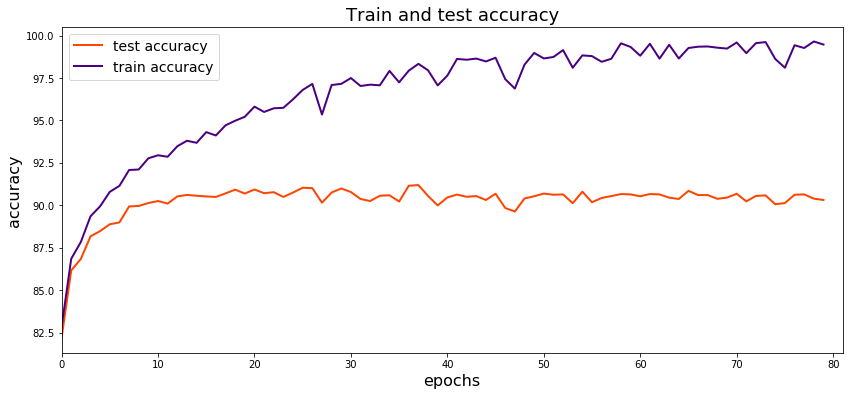

In [0]:
nums = np.arange(0, 80)
plt.figure(figsize=(14, 6))
plt.plot(nums, test_acc, color='orangered', lw=2, label='test accuracy')
plt.plot(nums, train_acc, color='indigo', lw=2, label='train accuracy')
    
plt.xlim([0, 81])
#plt.ylim([0.0, 1.1])
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('accuracy', fontsize = 16)
plt.title('Train and test accuracy', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

Как можно заметить по графику, в какой-то момент на тесте качество перестало расти, замерев около значения 90%, в то время как на train-е оно приближалось к 100%.

Попробуем немного исправить эту ситуацию (хотим, чтобы на test-е тоже появилось какое-то улучшение), добавив в модель, например, dropout-ы.

Итак, наша улучшенная модель:

In [0]:
class FashionModelOverfitted2Cured2(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
                                
        self.l5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(128),
            nn.ReLU(), 
        )
         
        self.flatten = Flatten()
        self.dp1 = nn.Dropout(0.3)
        self.dp2 = nn.Dropout(0.2)
        self.dp3 = nn.Dropout(0.4)

    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = self.dp1(output)
        output = self.l3(output)
        output = self.dp2(output)
        output = self.l4(output)
        output = self.dp3(output)
        output = self.l5(output)
        output = self.flatten(output)
        return output

In [0]:
loss_criteria = nn.CrossEntropyLoss()
model_for_overfit_cured2 = FashionModelOverfitted2Cured2().to(device)
optimizer_c2 = torch.optim.Adam(model_for_overfit_cured2.parameters(), lr=0.001)

test_acc_cured2, train_acc_cured2 = train_show_overfit(model_for_overfit_cured2, optimizer_c)

Model train accuracy in epoch 1 is: 83.97666666666666 %
Model test accuracy in epoch 1 is: 83.05 %
Model train accuracy in epoch 2 is: 86.66166666666668 %
Model test accuracy in epoch 2 is: 85.90000000000002 %
Model train accuracy in epoch 3 is: 88.58666666666667 %
Model test accuracy in epoch 3 is: 87.63999999999999 %
Model train accuracy in epoch 4 is: 89.00833333333333 %
Model test accuracy in epoch 4 is: 88.04999999999998 %
Model train accuracy in epoch 5 is: 89.44 %
Model test accuracy in epoch 5 is: 88.33 %
Model train accuracy in epoch 6 is: 90.52999999999999 %
Model test accuracy in epoch 6 is: 88.89000000000001 %
Model train accuracy in epoch 7 is: 90.72166666666665 %
Model test accuracy in epoch 7 is: 89.07999999999998 %
Model train accuracy in epoch 8 is: 91.12 %
Model test accuracy in epoch 8 is: 89.72999999999999 %
Model train accuracy in epoch 9 is: 91.15666666666668 %
Model test accuracy in epoch 9 is: 89.66 %
Model train accuracy in epoch 10 is: 91.75166666666667 %
Mode

In [0]:
print('Test accuracies ', test_acc_cured2)
print('Train accuracies ', train_acc_cured2) 

Test accuracies  [83.05, 85.90000000000002, 87.63999999999999, 88.04999999999998, 88.33, 88.89000000000001, 89.07999999999998, 89.72999999999999, 89.66, 90.04, 89.97999999999999, 90.0, 90.06000000000002, 90.56, 90.67999999999999, 90.46, 90.67, 90.86999999999999, 90.76, 91.02, 90.9, 90.51000000000002, 91.17999999999999, 90.89000000000001, 91.09000000000002, 90.94999999999999, 91.26, 91.21, 91.37, 91.19000000000001, 91.45, 91.11999999999999, 91.36999999999999, 91.31, 91.00000000000001, 91.23, 91.49999999999999, 91.59, 91.41, 91.81, 91.38000000000001, 91.60000000000001, 91.48, 91.80999999999999, 91.64000000000001, 91.46, 91.48, 91.71, 91.42999999999999, 91.68, 91.52999999999999, 91.67, 91.69000000000001, 91.21, 91.7, 91.69, 91.44999999999999, 91.36, 91.1, 91.72999999999999, 91.59, 91.62, 91.46, 91.70999999999998, 91.70000000000002, 91.10000000000001, 91.69999999999997, 91.68, 91.67000000000002, 91.64, 91.69000000000001, 91.95, 91.81, 91.89, 91.70000000000002, 91.75, 91.67999999999999, 91.

Построим теперь новый график, на этот раз для новых значений:

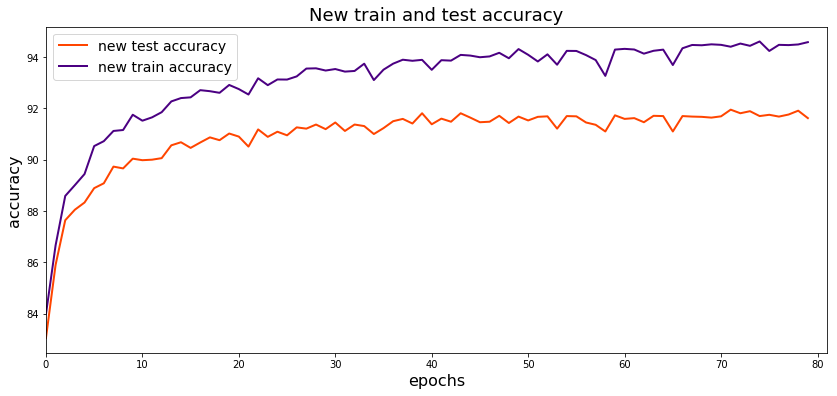

In [0]:
nums = np.arange(0, 80)
plt.figure(figsize=(14, 6))
plt.plot(nums, test_acc_cured2, color='orangered', lw=2, label='new test accuracy')
plt.plot(nums, train_acc_cured2, color='indigo', lw=2, label='new train accuracy')
    
plt.xlim([0, 81])
#plt.ylim([0.0, 1.1])
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('accuracy', fontsize = 16)
plt.title('New train and test accuracy', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

Как мы можем заметить, разница между accuracy на тестовой и обучающей выборках уже не такая сильная. И если на обучающей точность немного снизилась, то на тестовой она поднялась (примерно на 1,5-2 процента). 

Таким образом, у нас получилось немного побороть переобучение.

### Часть 2. Almost Shakespeare (1.5 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/sonnets.txt" "sonnets.txt"

In [0]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [0]:
import string

In [12]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

new_text = ''
for s in text:
    new_text += str(s).lower()
  
text = new_text

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [0]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [0]:
# словарь вида <индекс>:<символ>
# Your great code here

idx_to_token = dict(enumerate(tokens))
    
# словарь вида <символ>:<индекс>

token_to_idx = {}
for i in range(len(tokens)):
    element = {idx_to_token[i] : i}
    token_to_idx.update(element)

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

Строим нашу модель:

In [0]:
class RNNModel(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64, num_layers = 1):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens           #input and output sizes
        self.num_layers = num_layers
        self.embedding_size = embedding_size
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, num_layers)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, h_prev):
        
        x_emb = self.embedding(x)
        x_and_h = torch.cat([h_prev, x_emb], dim=-1)
        x_and_h, _ = self.rnn(x_and_h)
        
        x_and_h = self.dropout(x_and_h)
        logits = self.rnn_to_logits(x_and_h[-1])
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        #return Variable(torch.zeros(batch_size, self.num_units))

In [0]:
# PARAMETERS

MAX_LEN = 50

In [0]:
# divide textinto train and test
num_samples = int(len(text) / MAX_LEN)
X, Y = [], []

def turn_into_ind(XX):
    X_ind = [token_to_idx[sym] for w in XX for sym in w]
    return X_ind
  
for i in range (num_samples):
    new_X = text[i*MAX_LEN : (i+1)*MAX_LEN]
    new_Y = token_to_idx[text[(i+1)*MAX_LEN]]
    X.append(new_X)
    Y.append(new_Y)
    
X_length = len(X)

X_inx = turn_into_ind(X)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.reshape(np.array(X_inx), (X_length, MAX_LEN)), Y, test_size=0.1)

In [0]:
model = RNNModel()

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
loss_criteria = nn.CrossEntropyLoss()

*Прим.:* Модель выше не доделана, дальше уже будет идти третье задание.

Постройте график функции потерь в зависимости от номера эпохи.

In [0]:
# Your plot code here

In [0]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [0]:
# Your beautiful code here

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [0]:
# Text generation with different tempearature values here

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________

Части задания 3 (HAR classification) и 4 (kaggle) доступны на выбор. Вы можете выполнить одну из них, или обе.

### Часть 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [0]:
!cp "/content/drive/My Drive/X_train.txt" "X_train.txt"
!cp "/content/drive/My Drive/y_train.txt" "y_train.txt"

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

*Прим.:* Я тут немножко код поменяла в той части, где пути к файлам, так в колабе было удобнее сделать.

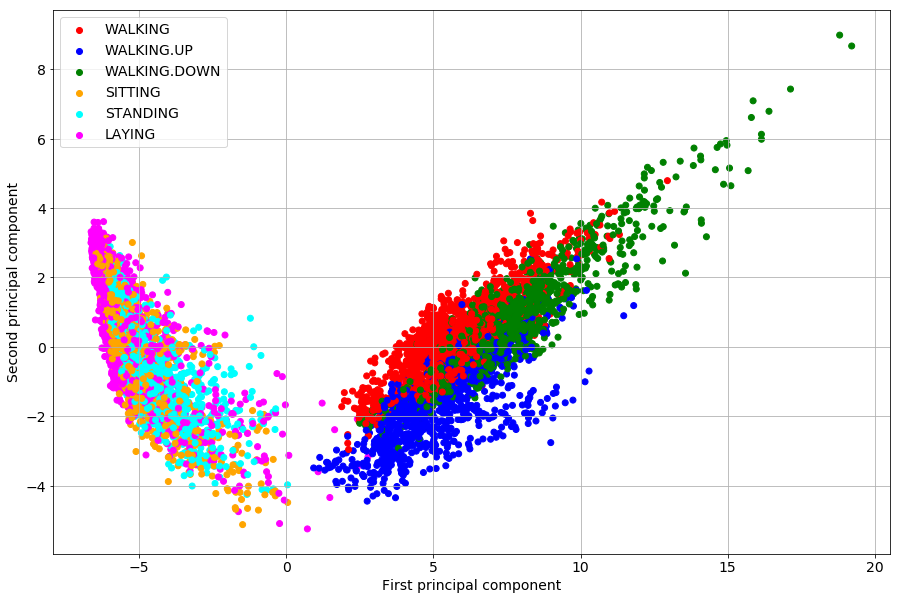

In [0]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("X_train.txt"))
y_train = np.genfromtxt(os.path.join("y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

*Прим.:* Тут тоже пришлось пути немного поменять (директории нормально не загрузились, так что извините, пожалуйста, за следующий блок с отдельной загрузкой файлов).

In [0]:
# загрузим все, что понадобится 

!cp "/content/drive/My Drive/harwork/body_acc_x_train.txt" "body_acc_x_train.txt"
!cp "/content/drive/My Drive/body_acc_y_train.txt" "body_acc_y_train.txt"
!cp "/content/drive/My Drive/harwork/body_acc_z_train.txt" "body_acc_z_train.txt"
!cp "/content/drive/My Drive/body_acc_x_test.txt" "body_acc_x_test.txt"
!cp "/content/drive/My Drive/body_acc_y_test.txt" "body_acc_y_test.txt"
!cp "/content/drive/My Drive/body_acc_z_test.txt" "body_acc_z_test.txt"

!cp "/content/drive/My Drive/body_gyro_x_train.txt" "body_gyro_x_train.txt"
!cp "/content/drive/My Drive/body_gyro_y_train.txt" "body_gyro_y_train.txt"
!cp "/content/drive/My Drive/body_gyro_z_train.txt" "body_gyro_z_train.txt"
!cp "/content/drive/My Drive/harwork/body_gyro_x_test.txt" "body_gyro_x_test.txt"
!cp "/content/drive/My Drive/body_gyro_y_test.txt" "body_gyro_y_test.txt"
!cp "/content/drive/My Drive/body_gyro_z_test.txt" "body_gyro_z_test.txt"

!cp "/content/drive/My Drive/total_acc_x_train.txt" "total_acc_x_train.txt"
!cp "/content/drive/My Drive/total_acc_y_train.txt" "total_acc_y_train.txt"
!cp "/content/drive/My Drive/total_acc_z_train.txt" "total_acc_z_train.txt"
!cp "/content/drive/My Drive/total_acc_x_test.txt" "total_acc_x_test.txt"
!cp "/content/drive/My Drive/harwork/total_acc_y_test.txt" "total_acc_y_test.txt"
!cp "/content/drive/My Drive/total_acc_z_test.txt" "total_acc_z_test.txt"


In [0]:
!cp "/content/drive/My Drive/harwork/y_test.txt" "y_test.txt"

In [0]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join("y_train.txt")
y_test_path = os.path.join("y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [0]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 85%.__
Разбалловка следующая:
* $=$85% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

Для выполнения задания я попробую постепенно улучшать модель, начав с довольно простой и каждый раз ее дополняя и получая результаты получше.

Развивать буду модель с использованием CNN (просто потому что с ней более-менее разобралась в момент выполнения первого задания)

1. Рассмотрим первую и самую простую модель. Пусть у нас будет 3 слоя (первые два похожи на те, что были в первой задаче (состоят из conv+relu+maxpool), последний - просто линейный с ReLU в качестве активации).

In [0]:
class HARModel1(nn.Module):
    def __init__(self):
        super(HARModel1, self).__init__()        
        self.l1 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Linear(64*3, 6), 
            nn.ReLU(), 
        )
        
    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = output.view(output.size(0),-1)
        output = self.l3(output)
        return output

In [0]:
EPOCH_NUM = 500

BATCH_SIZE = 100

In [0]:
X_Ttrain = torch.Tensor(X_train)
X_Ttrain = X_Ttrain.to(device)
X_Ttest = torch.Tensor(X_test)
X_Ttest = X_Ttest.to(device)

y_Ttrain = torch.Tensor(y_train)
y_Ttest = torch.Tensor(y_test)
y_Ttrain = y_Ttrain.long()
y_Ttest = y_Ttest.long()

Добавим, как и в первой задаче, train, test dataloaders.

In [0]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
class Create_data_loader(Dataset):
    def __init__(self, x, y, transformer):
        self.x = x
        self.y = y
        self.trans = transformer

    def __getitem__(self, ind):
        got_x = self.x[ind]
        got_x = self.trans(got_x)
        got_y = self.y[ind]
        return got_x, got_y

    def __len__(self):
        return len(self.x)

За счет класса выше получилось не очень, так что другой вариант:

In [0]:
from torch.utils.data import TensorDataset

In [0]:
transformer = transforms.Compose([
        transforms.ToTensor(),
])

data_train = TensorDataset(X_Ttrain, y_Ttrain)
data_test = TensorDataset(X_Ttest, y_Ttest)

har_train_loader = DataLoader(data_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

har_test_loader = DataLoader(data_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

Определим следующие две функции сразу для всех моделей:

In [0]:
def train_har(model, opt):
    total_train_loss = []
    for epoch in range(EPOCH_NUM):
        train_loss = [] 
        
        model.train(True)
        for i, (X, y) in enumerate(har_train_loader):
            X, y = X.to(device), y.to(device, dtype=torch.long)
            res = model(X)
            optimizer.zero_grad()
            loss = loss_criteria(res, y.squeeze())
            loss.backward()
            optimizer.step()

            train_loss.append(loss.cpu().data.numpy())

        print('This is epoch {} of {}'.format(epoch + 1, EPOCH_NUM))
        train_loss_current = np.mean(train_loss[-len(har_train_loader) // BATCH_SIZE :])
        total_train_loss.append(train_loss_current)
        print('Model train loss: \t{:.5f}'.format(train_loss_current))
        print('-----------------------------------')     
    return train_loss

In [0]:
def test_har(model):
    predicted = 0
    all_items = 0
    
    model.train(False)
    with torch.no_grad():
        for X, y, in har_test_loader:
            X, y = X.to(device), y.to(device)
            res = model(X)
            pred = torch.argmax(res, dim=1)
            all_items += y.size(0)
            predicted += torch.sum(pred == y.detach().squeeze())
        total_test_acc = predicted.to(dtype=torch.float) / 2947
        print('Model test accuracy is: {} %'.format(100 * total_test_acc))

In [0]:
har_model_1 = HARModel1().to(device)

loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(har_model_1.parameters(), lr=3e-4)

train_har(har_model_1, optimizer)

This is epoch 1 of 500
Model train loss: 	1.18466
-----------------------------------
This is epoch 2 of 500
Model train loss: 	0.89846
-----------------------------------
This is epoch 3 of 500
Model train loss: 	1.02168
-----------------------------------
This is epoch 4 of 500
Model train loss: 	0.60593
-----------------------------------
This is epoch 5 of 500
Model train loss: 	0.81675
-----------------------------------
This is epoch 6 of 500
Model train loss: 	0.81100
-----------------------------------
This is epoch 7 of 500
Model train loss: 	0.53541
-----------------------------------
This is epoch 8 of 500
Model train loss: 	0.35379
-----------------------------------
This is epoch 9 of 500
Model train loss: 	0.35968
-----------------------------------
This is epoch 10 of 500
Model train loss: 	0.47993
-----------------------------------
This is epoch 11 of 500
Model train loss: 	0.45808
-----------------------------------
This is epoch 12 of 500
Model train loss: 	0.41829
-

[array(0.28668925, dtype=float32),
 array(0.41212162, dtype=float32),
 array(0.32254612, dtype=float32),
 array(0.286706, dtype=float32),
 array(0.28669044, dtype=float32),
 array(0.3046021, dtype=float32),
 array(0.3225254, dtype=float32),
 array(0.32253018, dtype=float32),
 array(0.23294662, dtype=float32),
 array(0.35863763, dtype=float32),
 array(0.4479474, dtype=float32),
 array(0.39419636, dtype=float32),
 array(0.4300573, dtype=float32),
 array(0.28669503, dtype=float32),
 array(0.3941901, dtype=float32),
 array(0.34052178, dtype=float32),
 array(0.4479752, dtype=float32),
 array(0.2687659, dtype=float32),
 array(0.39420575, dtype=float32),
 array(0.35835922, dtype=float32),
 array(0.34047204, dtype=float32),
 array(0.37629506, dtype=float32),
 array(0.39430702, dtype=float32),
 array(0.37630707, dtype=float32),
 array(0.21503878, dtype=float32),
 array(0.3763882, dtype=float32),
 array(0.44795394, dtype=float32),
 array(0.34050152, dtype=float32),
 array(0.28672945, dtype=float

In [0]:
test_har(har_model_1)

Model test accuracy is: 77.84187316894531 %


Как можно заметить, accuracy довольно маленькая, поэтому улучшаем модель.

2. Вторая модель: добавляем еще линейные слои! 

In [0]:
class HARModel2(nn.Module):
    def __init__(self):
        super(HARModel2, self).__init__()        
        self.l1 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Linear(64*3, 64), 
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.Linear(64, 32), 
            nn.ReLU(), 
        )
        
        self.l5 = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(), 
        )
        
        self.l6 = nn.Sequential(
            nn.Linear(16, 6), 
            nn.ReLU(), 
        )
        
    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = output.view(output.size(0),-1)
        output = self.l3(output)
        output = self.l4(output)
        output = self.l5(output)
        output = self.l6(output)
        return output

In [0]:
har_model_2 = HARModel2().to(device)

loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(har_model_2.parameters(), lr=3e-4)

train_har(har_model_2, optimizer)

This is epoch 1 of 500
Model train loss: 	1.56049
-----------------------------------
This is epoch 2 of 500
Model train loss: 	0.90161
-----------------------------------
This is epoch 3 of 500
Model train loss: 	0.95855
-----------------------------------
This is epoch 4 of 500
Model train loss: 	0.78412
-----------------------------------
This is epoch 5 of 500
Model train loss: 	0.93490
-----------------------------------
This is epoch 6 of 500
Model train loss: 	0.77044
-----------------------------------
This is epoch 7 of 500
Model train loss: 	0.40624
-----------------------------------
This is epoch 8 of 500
Model train loss: 	0.45801
-----------------------------------
This is epoch 9 of 500
Model train loss: 	0.21615
-----------------------------------
This is epoch 10 of 500
Model train loss: 	0.43734
-----------------------------------
This is epoch 11 of 500
Model train loss: 	0.48017
-----------------------------------
This is epoch 12 of 500
Model train loss: 	0.44334
-

[array(0.19714004, dtype=float32),
 array(0.17921817, dtype=float32),
 array(0.2150875, dtype=float32),
 array(0.286706, dtype=float32),
 array(0.17933606, dtype=float32),
 array(0.10761924, dtype=float32),
 array(0.2329672, dtype=float32),
 array(0.21509068, dtype=float32),
 array(0.19711533, dtype=float32),
 array(0.28671134, dtype=float32),
 array(0.32257852, dtype=float32),
 array(0.2331052, dtype=float32),
 array(0.3585068, dtype=float32),
 array(0.28669873, dtype=float32),
 array(0.34048793, dtype=float32),
 array(0.26901108, dtype=float32),
 array(0.30465764, dtype=float32),
 array(0.25093487, dtype=float32),
 array(0.21506691, dtype=float32),
 array(0.30479306, dtype=float32),
 array(0.23303877, dtype=float32),
 array(0.25102103, dtype=float32),
 array(0.25107038, dtype=float32),
 array(0.21510518, dtype=float32),
 array(0.30467474, dtype=float32),
 array(0.3225817, dtype=float32),
 array(0.2330849, dtype=float32),
 array(0.30462357, dtype=float32),
 array(0.37634292, dtype=flo

Смотрим, какую получим точность:

In [0]:
test_har(har_model_2)

Model test accuracy is: 77.12928771972656 %


Результат вышел хуже, чем в первом пункте (ненамного), так что количество слоев пробуем как-то усреднить.

3. Третья модель: делаем 4-5 слоев, добавляем dropouts.



In [0]:
class HARModel3(nn.Module):
    def __init__(self):
        super(HARModel3, self).__init__()        
        self.l1 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Linear(64*3, 64), 
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.Linear(64, 16), 
            nn.ReLU(), 
        )
            
        self.l5 = nn.Sequential(
            nn.Linear(16, 6), 
            nn.ReLU(), 
        )
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = output.view(output.size(0),-1)
        output = self.l3(output)
        output = self.dropout1(output)
        output = self.l4(output)
        output = self.dropout2(output)
        output = self.l5(output)
        return output

In [0]:
har_model_3 = HARModel3().to(device)

loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(har_model_3.parameters(), lr=3e-4)

train_har(har_model_3, optimizer)

This is epoch 1 of 500
Model train loss: 	1.51344
-----------------------------------
This is epoch 2 of 500
Model train loss: 	1.24008
-----------------------------------
This is epoch 3 of 500
Model train loss: 	0.98762
-----------------------------------
This is epoch 4 of 500
Model train loss: 	0.89205
-----------------------------------
This is epoch 5 of 500
Model train loss: 	0.88261
-----------------------------------
This is epoch 6 of 500
Model train loss: 	0.65978
-----------------------------------
This is epoch 7 of 500
Model train loss: 	1.00301
-----------------------------------
This is epoch 8 of 500
Model train loss: 	0.60226
-----------------------------------
This is epoch 9 of 500
Model train loss: 	0.81849
-----------------------------------
This is epoch 10 of 500
Model train loss: 	0.61084
-----------------------------------
This is epoch 11 of 500
Model train loss: 	0.50835
-----------------------------------
This is epoch 12 of 500
Model train loss: 	0.53239
-

[array(0.0223767, dtype=float32),
 array(0.01550507, dtype=float32),
 array(0.0051403, dtype=float32),
 array(0.01301384, dtype=float32),
 array(0.00944499, dtype=float32),
 array(0.01152207, dtype=float32),
 array(0.00027538, dtype=float32),
 array(0.01565524, dtype=float32),
 array(0.00253332, dtype=float32),
 array(0.00248745, dtype=float32),
 array(0.01227851, dtype=float32),
 array(0.00294094, dtype=float32),
 array(0.00351832, dtype=float32),
 array(0.00998519, dtype=float32),
 array(0.00753623, dtype=float32),
 array(0.0017617, dtype=float32),
 array(0.00063038, dtype=float32),
 array(0.01211894, dtype=float32),
 array(0.00872512, dtype=float32),
 array(0.01905321, dtype=float32),
 array(0.00452024, dtype=float32),
 array(0.00547433, dtype=float32),
 array(0.01521218, dtype=float32),
 array(0.00351109, dtype=float32),
 array(0.00611378, dtype=float32),
 array(0.01070221, dtype=float32),
 array(0.05661184, dtype=float32),
 array(0.07081023, dtype=float32),
 array(0.05833796, dtyp

In [0]:
test_har(har_model_3)

Model test accuracy is: 93.38310241699219 %


В этот раз точность получилась довольно хорошая, что немного странно, потому что модель была оптимизирована с прошлого раза не слишком сильно. 

На всякий случай попробуем еще один вариант в пункте 4.

4. Добавляем BatchNorm для ускорения обучения слоев.

In [0]:
class HARModel4(nn.Module):
    def __init__(self):
        super(HARModel4, self).__init__()        
        self.l1 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=2), 
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.l3 = nn.Sequential(
            nn.Linear(64*3, 64), 
            nn.ReLU(), 
        )
        
        self.l4 = nn.Sequential(
            nn.Linear(64, 16), 
            nn.ReLU(), 
        )
            
        self.l5 = nn.Sequential(
            nn.Linear(16, 6), 
            nn.ReLU(), 
        )
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, input):
        output = self.l1(input)
        output = self.l2(output)
        output = output.view(output.size(0),-1)
        output = self.l3(output)
        output = self.dropout1(output)
        output = self.l4(output)
        output = self.dropout2(output)
        output = self.l5(output)
        return output

In [0]:
har_model_4 = HARModel4().to(device)

loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(har_model_4.parameters(), lr=3e-4)

train_har(har_model_4, optimizer)

This is epoch 1 of 500
Model train loss: 	1.35773
-----------------------------------
This is epoch 2 of 500
Model train loss: 	1.06423
-----------------------------------
This is epoch 3 of 500
Model train loss: 	0.66039
-----------------------------------
This is epoch 4 of 500
Model train loss: 	0.43932
-----------------------------------
This is epoch 5 of 500
Model train loss: 	0.35597
-----------------------------------
This is epoch 6 of 500
Model train loss: 	0.28445
-----------------------------------
This is epoch 7 of 500
Model train loss: 	0.24643
-----------------------------------
This is epoch 8 of 500
Model train loss: 	0.20930
-----------------------------------
This is epoch 9 of 500
Model train loss: 	0.24065
-----------------------------------
This is epoch 10 of 500
Model train loss: 	0.19461
-----------------------------------
This is epoch 11 of 500
Model train loss: 	0.22695
-----------------------------------
This is epoch 12 of 500
Model train loss: 	0.16579
-

[array(0.02215658, dtype=float32),
 array(0.00214746, dtype=float32),
 array(0.00845243, dtype=float32),
 array(0.02349098, dtype=float32),
 array(0.02300728, dtype=float32),
 array(0.00726283, dtype=float32),
 array(0.01313918, dtype=float32),
 array(0.00776134, dtype=float32),
 array(0.00611328, dtype=float32),
 array(0.00472981, dtype=float32),
 array(0.01217584, dtype=float32),
 array(0.01044747, dtype=float32),
 array(0.02442334, dtype=float32),
 array(0.00201636, dtype=float32),
 array(0.00518609, dtype=float32),
 array(0.01542187, dtype=float32),
 array(0.03893435, dtype=float32),
 array(0.024724, dtype=float32),
 array(0.00139586, dtype=float32),
 array(0.0316226, dtype=float32),
 array(0.00752429, dtype=float32),
 array(0.01240049, dtype=float32),
 array(0.01481845, dtype=float32),
 array(0.02082252, dtype=float32),
 array(0.02253283, dtype=float32),
 array(0.01766019, dtype=float32),
 array(0.00706748, dtype=float32),
 array(0.02375651, dtype=float32),
 array(0.00285312, dtyp

Получаем результат:

In [0]:
test_har(har_model_4)

Model test accuracy is: 92.2293930053711 %


Итак, в ходе данного задания получилось, что последовательность из Conv + Relu + MaxPool дает довольно неплохой результат.

От количества линейных слоев зависит мало, получилась разница менее 1%.

Очень большую пользу принесло добавление Dropout.

Как вывод, можно сказать, что наиболее полезным стало использование Dropout, точность получилась довольно неплохая, обучилась модель довольно быстро.

### Часть 4. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points